In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from neo4j import GraphDatabase
import collections
import matplotlib.pyplot as plt
from collections import Counter
from tabulate import tabulate
import pylab as p
from scipy.optimize import curve_fit
import random

In [2]:
driver = GraphDatabase.driver('bolt://localhost:7687', auth=("neo4j", "test"))
query="MATCH (n)-[r]-(m)WHERE NOT m:Address And NOT n:Address RETURN *"
results = driver.session(database="panama").run(query)

In [3]:
G = nx.Graph()

nodes = list(results.graph()._nodes.values())
for node in nodes:
    G.add_node(node.id, kind=list(node.labels)[0], properties=node._properties)

rels = list(results.graph()._relationships.values())
for rel in rels:
    G.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)
len(G.nodes)

465786

In [16]:
# Graph connected components
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
print('The total number of components is: ',len(S))
G=S[0]

The total number of components is:  12219


In [17]:
## Get nodes by kind. Output: map[kind]=[]
labels = {}
for n, d in G.nodes(data=True):
    l = d['kind']
    labels[l] = labels.get(l, [])
    labels[l].append(n)
print('Number of Entity nodes:', len(labels['Entity']), ' ====> Proportion(%):', round(len(labels['Entity'])/len(G.nodes)*100,2))
print('Number of Officer nodes:', len(labels['Officer']),' ====> Proportion(%):', round(len(labels['Officer'])/len(G.nodes)*100,2))
print('Number of Intermediary nodes:', len(labels['Intermediary']), ' ====> Proportion(%):', round(len(labels['Intermediary'])/len(G.nodes)*100,2))

Number of Entity nodes: 146005  ====> Proportion(%): 47.0
Number of Officer nodes: 162907  ====> Proportion(%): 52.44
Number of Intermediary nodes: 1762  ====> Proportion(%): 0.57


In [18]:
def get_ids_intermediaries(G,tupla,id_intermediary):
    ids_intermediaries = []
    entities_object = G.edges(tupla[1])
    for entity_neighbors in entities_object:
        # if it's officer
        if G.nodes[entity_neighbors[1]]['kind'] == 'Officer':
            id_officer = entity_neighbors[1]
            # Iteramos por sus vecinos
            for entidades_vecinas_officer in G.edges(id_officer):
                # Iteramos las entidades de ese officer
                for adjacencias_entidad in G.edges(entidades_vecinas_officer[1]):
                    # Si es un intermediario, no es el mismo que el que vamos a eliminar y no existe ya
                    if G.nodes[adjacencias_entidad[1]]['kind'] == 'Intermediary':
                        if id_intermediary != adjacencias_entidad[1] and adjacencias_entidad[1] not in ids_intermediaries:
                            ids_intermediaries.append(adjacencias_entidad[1])
                        break
    return ids_intermediaries

def recompute_edges(G,id_intermediary):
    vueltas = 0
    for i in G.edges(id_intermediary):
        new_id_intermediaries = get_ids_intermediaries(G,i,id_intermediary)
        if new_id_intermediaries:
            max_degree_id = max(dict(G.degree(new_id_intermediaries)), key=dict(G.degree(new_id_intermediaries)).get)
            G.add_edge(max_degree_id, i[1], key=G[id_intermediary][i[1]], type='INTERMEDIARY_OF')
        vueltas = vueltas+1
    print(vueltas)

In [19]:
## Percolation for GCC
"""
total_graph = G.number_of_nodes()
scatter_gcc = [[0,1]]
scatter_slcc = [[0,0]]
scatter_cc = [[0,1]]
current_length_gcc = total_graph
Percolation_graph = G.copy()
i=1
while current_length_gcc/total_graph > 0.05:
    max_degree_id = max(dict(Percolation_graph.degree(labels['Intermediary'])), key=dict(Percolation_graph.degree(labels['Intermediary'])).get)
    recompute_edges(Percolation_graph,max_degree_id)
    Percolation_graph.remove_node(max_degree_id)
    G_sorted = sorted(nx.connected_components(Percolation_graph), key=len, reverse=True)
    scatter_cc.append([i,len(G_sorted)])
    Gcc = Percolation_graph.subgraph(G_sorted[0])
    Slcc = Percolation_graph.subgraph(G_sorted[1])
    current_length_gcc = len(Gcc)
    current_length_slcc = len(Slcc)
    print('The total number of components in Gcc is: ',current_length_gcc)
    print('The total number of components in Slcc is: ',current_length_slcc)
    print('Proportion gcc',current_length_gcc/total_graph)
    print('Proportion slcc',current_length_slcc/total_graph)
    scatter_gcc.append([i,current_length_gcc/total_graph])
    scatter_slcc.append([i,current_length_slcc/total_graph])
    i=i+1
    print(i)
"""
import ast
scatter_gcc = []
scatter_slcc = []
scatter_cc = []
with open('gcc_max_defense.txt') as file:
    lines = file.readlines()
    for line in lines:
        scatter_gcc.append(eval(line.strip()))
with open('slcc_max_defense.txt') as file:
    lines = file.readlines()
    for line in lines:
        scatter_slcc.append(eval(line.strip()))
with open('cc_max_defense.txt') as file:
    lines = file.readlines()
    for line in lines:
        scatter_cc.append(eval(line.strip()))
scatter_gcc

[[0, 1],
 [1, 0.9624590406664221],
 [2, 0.9511706805204169],
 [3, 0.9153517835415902],
 [4, 0.8912654422320503],
 [5, 0.8637092257478901],
 [6, 0.8494820937703187],
 [7, 0.8359373491183685],
 [8, 0.8240084461525586],
 [9, 0.8185429099313106],
 [10, 0.8075538989422997],
 [11, 0.8037943310351043],
 [12, 0.7966324829242228],
 [13, 0.7885468368772411],
 [14, 0.7862550454817591],
 [15, 0.7830491125745959],
 [16, 0.7758679516148761],
 [17, 0.7747574628066719],
 [18, 0.769938907021508],
 [19, 0.7679657776318585],
 [20, 0.7633628819920559],
 [21, 0.760733115741903],
 [22, 0.7587245794627165],
 [23, 0.7528405981833047],
 [24, 0.7412303572233273],
 [25, 0.735571692513696],
 [26, 0.7303765361761847],
 [27, 0.727061163792271],
 [28, 0.7232146880653032],
 [29, 0.7205527337337531],
 [30, 0.7191235829197165],
 [31, 0.7150453530066887],
 [32, 0.7140539600996543],
 [33, 0.712447774837933],
 [34, 0.7099596361459278],
 [35, 0.7045423820467758],
 [36, 0.7006089985000354],
 [37, 0.6985167732092161],
 [38, 

In [20]:
'''
with open('gcc_max_defensaae.txt', 'w') as f:
    for item in scatter_gcc:
        f.write("%s\n" % item)
with open('slcc_max_daaaefense.txt', 'w') as f:
    for item in scatter_slcc:
        f.write("%s\n" % item)
with open('cc_max_defaaaaense.txt', 'w') as f:
    for item in scatter_cc:
        f.write("%s\n" % item)
'''

'\nwith open(\'gcc_max_defensaae.txt\', \'w\') as f:\n    for item in scatter_gcc:\n        f.write("%s\n" % item)\nwith open(\'slcc_max_daaaefense.txt\', \'w\') as f:\n    for item in scatter_slcc:\n        f.write("%s\n" % item)\nwith open(\'cc_max_defaaaaense.txt\', \'w\') as f:\n    for item in scatter_cc:\n        f.write("%s\n" % item)\n'

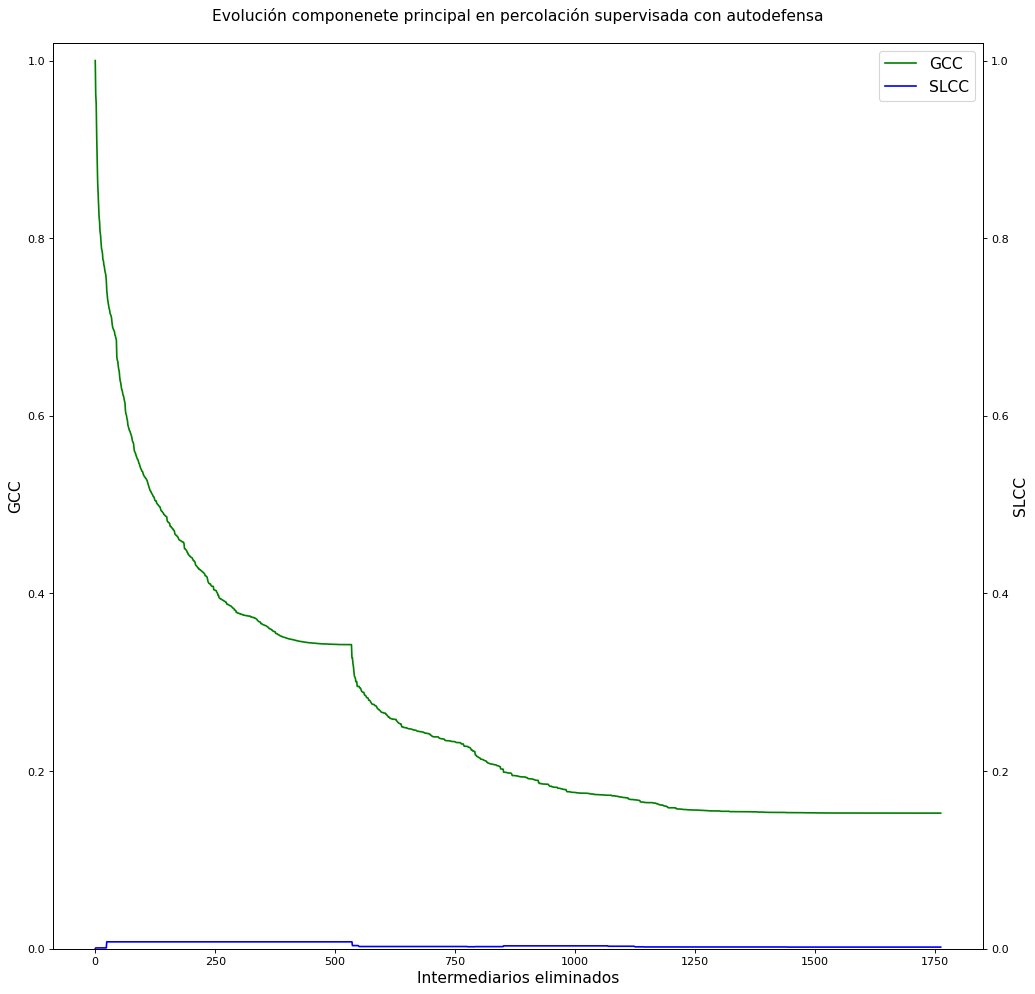

In [21]:
# Supervised percolation with autodefense plot
fig, ax1 = plt.subplots(figsize=(15,15),dpi=80)
ax1.set_title('Evolución componenete principal en percolación supervisada con autodefensa',fontsize=14,pad=20)
x_val_gcc = [x[0] for x in scatter_gcc]
y_val_gcc = [x[1] for x in scatter_gcc]
x_val_sgcc = [x[0] for x in scatter_slcc]
y_val_sgcc = [x[1] for x in scatter_slcc]

ax2 = ax1.twinx()
lns1 = ax1.plot(x_val_gcc, y_val_gcc, 'g-',label="GCC")
lns2 =ax2.plot(x_val_gcc, y_val_sgcc, 'b-',label="SLCC")
lns = lns1+lns2
ax1.set_xlabel('Intermediarios eliminados',fontsize=14)
ax1.set_ylim([0, 1.02])
ax2.set_ylim([0, 1.02])
ax1.set_ylabel('GCC',fontsize=14)
ax2.set_ylabel('SLCC',fontsize=14)
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0,fontsize=14)
plt.show()

In [22]:
def get_ids_intermediaries_random(G,tupla,id_intermediary):
    ids_intermediaries = []
    entities_object = G.edges(tupla[1])
    for entity_neighbors in entities_object:
        # if it's officer
        if G.nodes[entity_neighbors[1]]['kind'] == 'Officer':
            id_officer = entity_neighbors[1]
            # Iteramos por sus vecinos
            for entidades_vecinas_officer in G.edges(id_officer):
                # Iteramos las entidades de ese officer
                for adjacencias_entidad in G.edges(entidades_vecinas_officer[1]):
                    # Si es un intermediario, no es el mismo que el que vamos a eliminar y no existe ya
                    if G.nodes[adjacencias_entidad[1]]['kind'] == 'Intermediary':
                        if id_intermediary != adjacencias_entidad[1] and adjacencias_entidad[1] not in ids_intermediaries:
                            ids_intermediaries.append(adjacencias_entidad[1])
                        break
    return ids_intermediaries

def recompute_edges_random(G,id_intermediary):
    vueltas = 0
    for i in G.edges(id_intermediary):
        new_id_intermediaries = get_ids_intermediaries(G,i,id_intermediary)
        if new_id_intermediaries:
            max_degree_id = random.choice(new_id_intermediaries)
            G.add_edge(max_degree_id, i[1], key=G[id_intermediary][i[1]], type='INTERMEDIARY_OF')
        vueltas = vueltas+1
    print(vueltas)

In [23]:
## Random percolation for GCC
total_graph = G.number_of_nodes()
scatters_dict = {}
scatter_random_gcc = [[0,1]]
scatter_random_slcc = [[0,0]]
scatter__random_cc = [[0,1]]
current_length_gcc = total_graph
Percolation_graph = G.copy()
j=1

while current_length_gcc/total_graph > 0.05:
    random.seed(32)
    random_id = random.choice(list(dict(Percolation_graph.degree(labels['Intermediary'])).keys()))
    recompute_edges(Percolation_graph,random_id)
    Percolation_graph.remove_node(random_id)
    G_sorted = sorted(nx.connected_components(Percolation_graph), key=len, reverse=True)
    scatter__random_cc.append([j,len(G_sorted)])
    Gcc = Percolation_graph.subgraph(G_sorted[0])
    Slcc = Percolation_graph.subgraph(G_sorted[1])
    current_length_gcc = len(Gcc)
    current_length_slcc = len(Slcc)    
    print('The total number of components in Gcc is: ',current_length_gcc)
    print('The total number of components in Slcc is: ',current_length_slcc)
    print('Proportion gcc',current_length_gcc/total_graph)
    print('Proportion slcc',current_length_slcc/total_graph)    
    scatter_random_gcc.append([j,current_length_gcc/total_graph])
    scatter_random_slcc.append([j,current_length_slcc/total_graph])
    j=j+1

19
The total number of components in Gcc is:  310612
The total number of components in Slcc is:  8
Proportion gcc 0.9998004338953372
Proportion slcc 2.575046511777619e-05
7
The total number of components in Gcc is:  310583
The total number of components in Slcc is:  11
Proportion gcc 0.9997070884592852
Proportion slcc 3.540688953694226e-05
59
The total number of components in Gcc is:  310521
The total number of components in Slcc is:  11
Proportion gcc 0.9995075223546225
Proportion slcc 3.540688953694226e-05
6
The total number of components in Gcc is:  310509
The total number of components in Slcc is:  11
Proportion gcc 0.9994688966569458
Proportion slcc 3.540688953694226e-05
367
The total number of components in Gcc is:  309607
The total number of components in Slcc is:  149
Proportion gcc 0.9965655317149166
Proportion slcc 0.00047960241281858154
6
The total number of components in Gcc is:  309568
The total number of components in Slcc is:  149
Proportion gcc 0.9964399981974674
Propor

111
The total number of components in Gcc is:  304150
The total number of components in Slcc is:  309
Proportion gcc 0.9790004956964535
Proportion slcc 0.0009946117151741053
1
The total number of components in Gcc is:  304149
The total number of components in Slcc is:  309
Proportion gcc 0.9789972768883138
Proportion slcc 0.0009946117151741053
24
The total number of components in Gcc is:  304120
The total number of components in Slcc is:  309
Proportion gcc 0.9789039314522618
Proportion slcc 0.0009946117151741053
57
The total number of components in Gcc is:  304014
The total number of components in Slcc is:  309
Proportion gcc 0.9785627377894514
Proportion slcc 0.0009946117151741053
142
The total number of components in Gcc is:  303679
The total number of components in Slcc is:  309
Proportion gcc 0.9774844370626444
Proportion slcc 0.0009946117151741053
250
The total number of components in Gcc is:  303391
The total number of components in Slcc is:  309
Proportion gcc 0.976557420318404

The total number of components in Gcc is:  293223
The total number of components in Slcc is:  309
Proportion gcc 0.943828579153711
Proportion slcc 0.0009946117151741053
1
The total number of components in Gcc is:  293222
The total number of components in Slcc is:  309
Proportion gcc 0.9438253603455713
Proportion slcc 0.0009946117151741053
37
The total number of components in Gcc is:  293139
The total number of components in Slcc is:  309
Proportion gcc 0.9435581992699743
Proportion slcc 0.0009946117151741053
67
The total number of components in Gcc is:  292988
The total number of components in Slcc is:  309
Proportion gcc 0.9430721592408763
Proportion slcc 0.0009946117151741053
99
The total number of components in Gcc is:  292770
The total number of components in Slcc is:  309
Proportion gcc 0.9423704590664169
Proportion slcc 0.0009946117151741053
11
The total number of components in Gcc is:  292744
The total number of components in Slcc is:  309
Proportion gcc 0.9422867700547841
Propo

The total number of components in Gcc is:  281262
The total number of components in Slcc is:  2427
Proportion gcc 0.9053284149944958
Proportion slcc 0.007812047355105351
607
The total number of components in Gcc is:  280954
The total number of components in Slcc is:  2427
Proportion gcc 0.9043370220874615
Proportion slcc 0.007812047355105351
56
The total number of components in Gcc is:  280882
The total number of components in Slcc is:  2427
Proportion gcc 0.9041052679014014
Proportion slcc 0.007812047355105351
152
The total number of components in Gcc is:  280798
The total number of components in Slcc is:  2427
Proportion gcc 0.9038348880176649
Proportion slcc 0.007812047355105351
788
The total number of components in Gcc is:  279150
The total number of components in Slcc is:  2427
Proportion gcc 0.898530292203403
Proportion slcc 0.007812047355105351
3
The total number of components in Gcc is:  279149
The total number of components in Slcc is:  2427
Proportion gcc 0.8985270733952632
P

The total number of components in Gcc is:  274860
The total number of components in Slcc is:  2427
Proportion gcc 0.8847216052839955
Proportion slcc 0.007812047355105351
372
The total number of components in Gcc is:  274341
The total number of components in Slcc is:  2427
Proportion gcc 0.8830510438594797
Proportion slcc 0.007812047355105351
43
The total number of components in Gcc is:  274294
The total number of components in Slcc is:  2427
Proportion gcc 0.8828997598769128
Proportion slcc 0.007812047355105351
81
The total number of components in Gcc is:  274204
The total number of components in Slcc is:  2427
Proportion gcc 0.8826100671443378
Proportion slcc 0.007812047355105351
260
The total number of components in Gcc is:  273718
The total number of components in Slcc is:  2427
Proportion gcc 0.8810457263884329
Proportion slcc 0.007812047355105351
397
The total number of components in Gcc is:  273286
The total number of components in Slcc is:  2427
Proportion gcc 0.879655201272073


The total number of components in Gcc is:  264287
The total number of components in Slcc is:  2427
Proportion gcc 0.8506891468227145
Proportion slcc 0.007812047355105351
222
The total number of components in Gcc is:  263936
The total number of components in Slcc is:  2427
Proportion gcc 0.8495593451656721
Proportion slcc 0.007812047355105351
22
The total number of components in Gcc is:  263906
The total number of components in Slcc is:  2427
Proportion gcc 0.8494627809214804
Proportion slcc 0.007812047355105351
60
The total number of components in Gcc is:  263757
The total number of components in Slcc is:  2427
Proportion gcc 0.8489831785086618
Proportion slcc 0.007812047355105351
16
The total number of components in Gcc is:  263693
The total number of components in Slcc is:  2427
Proportion gcc 0.8487771747877196
Proportion slcc 0.007812047355105351
1
The total number of components in Gcc is:  263692
The total number of components in Slcc is:  2427
Proportion gcc 0.8487739559795798
Pr

The total number of components in Gcc is:  249491
The total number of components in Slcc is:  2427
Proportion gcc 0.8030636615873874
Proportion slcc 0.007812047355105351
333
The total number of components in Gcc is:  249118
The total number of components in Slcc is:  2427
Proportion gcc 0.8018630461512711
Proportion slcc 0.007812047355105351
14
The total number of components in Gcc is:  249088
The total number of components in Slcc is:  2427
Proportion gcc 0.8017664819070794
Proportion slcc 0.007812047355105351
2
The total number of components in Gcc is:  249085
The total number of components in Slcc is:  2427
Proportion gcc 0.8017568254826603
Proportion slcc 0.007812047355105351
116
The total number of components in Gcc is:  248915
The total number of components in Slcc is:  2427
Proportion gcc 0.8012096280989075
Proportion slcc 0.007812047355105351
1
The total number of components in Gcc is:  248914
The total number of components in Slcc is:  2427
Proportion gcc 0.8012064092907678
Pr

The total number of components in Gcc is:  241250
The total number of components in Slcc is:  2427
Proportion gcc 0.7765374637079382
Proportion slcc 0.007812047355105351
10
The total number of components in Gcc is:  241201
The total number of components in Slcc is:  2427
Proportion gcc 0.7763797421090919
Proportion slcc 0.007812047355105351
71
The total number of components in Gcc is:  240973
The total number of components in Slcc is:  2427
Proportion gcc 0.7756458538532353
Proportion slcc 0.007812047355105351
38
The total number of components in Gcc is:  240898
The total number of components in Slcc is:  2427
Proportion gcc 0.775404443242756
Proportion slcc 0.007812047355105351
139
The total number of components in Gcc is:  240712
The total number of components in Slcc is:  2427
Proportion gcc 0.7748057449287677
Proportion slcc 0.007812047355105351
23
The total number of components in Gcc is:  240687
The total number of components in Slcc is:  2427
Proportion gcc 0.7747252747252747
Pr

The total number of components in Gcc is:  235776
The total number of components in Slcc is:  2427
Proportion gcc 0.7589177079510999
Proportion slcc 0.007812047355105351
103
The total number of components in Gcc is:  235528
The total number of components in Slcc is:  2427
Proportion gcc 0.7581194435324488
Proportion slcc 0.007812047355105351
55
The total number of components in Gcc is:  235445
The total number of components in Slcc is:  2427
Proportion gcc 0.7578522824568519
Proportion slcc 0.007812047355105351
106
The total number of components in Gcc is:  235312
The total number of components in Slcc is:  2427
Proportion gcc 0.7574241809742689
Proportion slcc 0.007812047355105351
36
The total number of components in Gcc is:  235288
The total number of components in Slcc is:  2427
Proportion gcc 0.7573469295789155
Proportion slcc 0.007812047355105351
72
The total number of components in Gcc is:  235087
The total number of components in Slcc is:  2427
Proportion gcc 0.7566999491428313


The total number of components in Gcc is:  227813
The total number of components in Slcc is:  2427
Proportion gcc 0.7332863387344933
Proportion slcc 0.007812047355105351
18
The total number of components in Gcc is:  227727
The total number of components in Slcc is:  2427
Proportion gcc 0.7330095212344773
Proportion slcc 0.007812047355105351
45
The total number of components in Gcc is:  227694
The total number of components in Slcc is:  2427
Proportion gcc 0.7329033005658665
Proportion slcc 0.007812047355105351
283
The total number of components in Gcc is:  227136
The total number of components in Slcc is:  2427
Proportion gcc 0.7311072056239016
Proportion slcc 0.007812047355105351
64
The total number of components in Gcc is:  227051
The total number of components in Slcc is:  2427
Proportion gcc 0.7308336069320253
Proportion slcc 0.007812047355105351
82
The total number of components in Gcc is:  226925
The total number of components in Slcc is:  2427
Proportion gcc 0.7304280371064202
P

The total number of components in Gcc is:  221103
The total number of components in Slcc is:  2427
Proportion gcc 0.7116881361169586
Proportion slcc 0.007812047355105351
54
The total number of components in Gcc is:  221038
The total number of components in Slcc is:  2427
Proportion gcc 0.7114789135878766
Proportion slcc 0.007812047355105351
45
The total number of components in Gcc is:  220921
The total number of components in Slcc is:  2427
Proportion gcc 0.7111023130355292
Proportion slcc 0.007812047355105351
3
The total number of components in Gcc is:  220921
The total number of components in Slcc is:  2427
Proportion gcc 0.7111023130355292
Proportion slcc 0.007812047355105351
116
The total number of components in Gcc is:  220814
The total number of components in Slcc is:  2427
Proportion gcc 0.710757900564579
Proportion slcc 0.007812047355105351
30
The total number of components in Gcc is:  220783
The total number of components in Slcc is:  2427
Proportion gcc 0.7106581175122476
Pro

The total number of components in Gcc is:  209217
The total number of components in Slcc is:  2427
Proportion gcc 0.6734293825682226
Proportion slcc 0.007812047355105351
8
The total number of components in Gcc is:  209216
The total number of components in Slcc is:  2427
Proportion gcc 0.6734261637600829
Proportion slcc 0.007812047355105351
10
The total number of components in Gcc is:  209202
The total number of components in Slcc is:  2427
Proportion gcc 0.6733811004461268
Proportion slcc 0.007812047355105351
23
The total number of components in Gcc is:  209152
The total number of components in Slcc is:  2427
Proportion gcc 0.6732201600391408
Proportion slcc 0.007812047355105351
4
The total number of components in Gcc is:  209152
The total number of components in Slcc is:  2427
Proportion gcc 0.6732201600391408
Proportion slcc 0.007812047355105351
151
The total number of components in Gcc is:  208796
The total number of components in Slcc is:  2427
Proportion gcc 0.6720742643413997
Pro

The total number of components in Gcc is:  200015
The total number of components in Slcc is:  2427
Proportion gcc 0.6438099100665006
Proportion slcc 0.007812047355105351
110
The total number of components in Gcc is:  199911
The total number of components in Slcc is:  2427
Proportion gcc 0.6434751540199695
Proportion slcc 0.007812047355105351
2
The total number of components in Gcc is:  199907
The total number of components in Slcc is:  2427
Proportion gcc 0.6434622787874106
Proportion slcc 0.007812047355105351
2
The total number of components in Gcc is:  199904
The total number of components in Slcc is:  2427
Proportion gcc 0.6434526223629914
Proportion slcc 0.007812047355105351
31
The total number of components in Gcc is:  199846
The total number of components in Slcc is:  2427
Proportion gcc 0.6432659314908875
Proportion slcc 0.007812047355105351
36
The total number of components in Gcc is:  199751
The total number of components in Slcc is:  2427
Proportion gcc 0.642960144717614
Prop

The total number of components in Gcc is:  196395
The total number of components in Slcc is:  2427
Proportion gcc 0.6321578246007068
Proportion slcc 0.007812047355105351
34
The total number of components in Gcc is:  196317
The total number of components in Slcc is:  2427
Proportion gcc 0.6319067575658085
Proportion slcc 0.007812047355105351
26
The total number of components in Gcc is:  196317
The total number of components in Slcc is:  2427
Proportion gcc 0.6319067575658085
Proportion slcc 0.007812047355105351
19
The total number of components in Gcc is:  196246
The total number of components in Slcc is:  2427
Proportion gcc 0.6316782221878883
Proportion slcc 0.007812047355105351
89
The total number of components in Gcc is:  196038
The total number of components in Slcc is:  2427
Proportion gcc 0.6310087100948261
Proportion slcc 0.007812047355105351
5
The total number of components in Gcc is:  196035
The total number of components in Slcc is:  2427
Proportion gcc 0.6309990536704069
Pro

The total number of components in Gcc is:  192568
The total number of components in Slcc is:  2427
Proportion gcc 0.6198394458499906
Proportion slcc 0.007812047355105351
34
The total number of components in Gcc is:  192482
The total number of components in Slcc is:  2427
Proportion gcc 0.6195626283499746
Proportion slcc 0.007812047355105351
270
The total number of components in Gcc is:  191907
The total number of components in Slcc is:  2427
Proportion gcc 0.6177118136696345
Proportion slcc 0.007812047355105351
70
The total number of components in Gcc is:  191887
The total number of components in Slcc is:  2427
Proportion gcc 0.6176474375068399
Proportion slcc 0.007812047355105351
24
The total number of components in Gcc is:  191830
The total number of components in Slcc is:  2427
Proportion gcc 0.6174639654428759
Proportion slcc 0.007812047355105351
331
The total number of components in Gcc is:  191486
The total number of components in Slcc is:  2427
Proportion gcc 0.6163566954428115


The total number of components in Gcc is:  187914
The total number of components in Slcc is:  2427
Proportion gcc 0.6048591127677244
Proportion slcc 0.007812047355105351
20
The total number of components in Gcc is:  187866
The total number of components in Slcc is:  2427
Proportion gcc 0.6047046099770177
Proportion slcc 0.007812047355105351
17
The total number of components in Gcc is:  187791
The total number of components in Slcc is:  2427
Proportion gcc 0.6044631993665386
Proportion slcc 0.007812047355105351
1
The total number of components in Gcc is:  187790
The total number of components in Slcc is:  2427
Proportion gcc 0.6044599805583989
Proportion slcc 0.007812047355105351
47
The total number of components in Gcc is:  187743
The total number of components in Slcc is:  2427
Proportion gcc 0.6043086965758319
Proportion slcc 0.007812047355105351
9
The total number of components in Gcc is:  187726
The total number of components in Slcc is:  2427
Proportion gcc 0.6042539768374566
Prop

The total number of components in Gcc is:  172134
The total number of components in Slcc is:  503
Proportion gcc 0.5540663203229108
Proportion slcc 0.0016190604942801778
16
The total number of components in Gcc is:  172113
The total number of components in Slcc is:  503
Proportion gcc 0.5539987253519767
Proportion slcc 0.0016190604942801778
30
The total number of components in Gcc is:  172065
The total number of components in Slcc is:  503
Proportion gcc 0.55384422256127
Proportion slcc 0.0016190604942801778
16
The total number of components in Gcc is:  172002
The total number of components in Slcc is:  503
Proportion gcc 0.5536414376484675
Proportion slcc 0.0016190604942801778
105
The total number of components in Gcc is:  171843
The total number of components in Slcc is:  503
Proportion gcc 0.5531296471542517
Proportion slcc 0.0016190604942801778
518
The total number of components in Gcc is:  170757
The total number of components in Slcc is:  503
Proportion gcc 0.5496340215145136
Pro

The total number of components in Gcc is:  152559
The total number of components in Slcc is:  503
Proportion gcc 0.4910581509878522
Proportion slcc 0.0016190604942801778
60
The total number of components in Gcc is:  152329
The total number of components in Slcc is:  503
Proportion gcc 0.49031782511571614
Proportion slcc 0.0016190604942801778
442
The total number of components in Gcc is:  151668
The total number of components in Slcc is:  503
Proportion gcc 0.48819019293535987
Proportion slcc 0.0016190604942801778
203
The total number of components in Gcc is:  151356
The total number of components in Slcc is:  503
Proportion gcc 0.4871859247957666
Proportion slcc 0.0016190604942801778
181
The total number of components in Gcc is:  151172
The total number of components in Slcc is:  503
Proportion gcc 0.48659366409805777
Proportion slcc 0.0016190604942801778
4
The total number of components in Gcc is:  151169
The total number of components in Slcc is:  503
Proportion gcc 0.486584007673638

The total number of components in Gcc is:  146572
The total number of components in Slcc is:  503
Proportion gcc 0.47178714665533644
Proportion slcc 0.0016190604942801778
24
The total number of components in Gcc is:  146521
The total number of components in Slcc is:  503
Proportion gcc 0.47162298744021064
Proportion slcc 0.0016190604942801778
22
The total number of components in Gcc is:  146486
The total number of components in Slcc is:  503
Proportion gcc 0.4715103291553204
Proportion slcc 0.0016190604942801778
145
The total number of components in Gcc is:  146422
The total number of components in Slcc is:  503
Proportion gcc 0.47130432543437817
Proportion slcc 0.0016190604942801778
6
The total number of components in Gcc is:  146414
The total number of components in Slcc is:  503
Proportion gcc 0.4712785749692604
Proportion slcc 0.0016190604942801778
7
The total number of components in Gcc is:  146400
The total number of components in Slcc is:  503
Proportion gcc 0.47123351165530425


The total number of components in Gcc is:  143585
The total number of components in Slcc is:  503
Proportion gcc 0.46217256674198676
Proportion slcc 0.0016190604942801778
3
The total number of components in Gcc is:  143578
The total number of components in Slcc is:  503
Proportion gcc 0.46215003508500874
Proportion slcc 0.0016190604942801778
39
The total number of components in Gcc is:  143513
The total number of components in Slcc is:  503
Proportion gcc 0.4619408125559268
Proportion slcc 0.0016190604942801778
9
The total number of components in Gcc is:  143499
The total number of components in Slcc is:  503
Proportion gcc 0.4618957492419707
Proportion slcc 0.0016190604942801778
9
The total number of components in Gcc is:  143499
The total number of components in Slcc is:  503
Proportion gcc 0.4618957492419707
Proportion slcc 0.0016190604942801778
5
The total number of components in Gcc is:  143490
The total number of components in Slcc is:  503
Proportion gcc 0.46186677996871317
Prop

The total number of components in Gcc is:  140924
The total number of components in Slcc is:  535
Proportion gcc 0.4536073182821865
Proportion slcc 0.0017220623547512827
20
The total number of components in Gcc is:  140924
The total number of components in Slcc is:  535
Proportion gcc 0.4536073182821865
Proportion slcc 0.0017220623547512827
7
The total number of components in Gcc is:  140924
The total number of components in Slcc is:  535
Proportion gcc 0.4536073182821865
Proportion slcc 0.0017220623547512827
44
The total number of components in Gcc is:  140924
The total number of components in Slcc is:  535
Proportion gcc 0.4536073182821865
Proportion slcc 0.0017220623547512827
2
The total number of components in Gcc is:  140924
The total number of components in Slcc is:  535
Proportion gcc 0.4536073182821865
Proportion slcc 0.0017220623547512827
11
The total number of components in Gcc is:  140924
The total number of components in Slcc is:  535
Proportion gcc 0.4536073182821865
Propo

The total number of components in Gcc is:  138627
The total number of components in Slcc is:  535
Proportion gcc 0.446213715985245
Proportion slcc 0.0017220623547512827
1
The total number of components in Gcc is:  138626
The total number of components in Slcc is:  535
Proportion gcc 0.44621049717710526
Proportion slcc 0.0017220623547512827
10
The total number of components in Gcc is:  138626
The total number of components in Slcc is:  535
Proportion gcc 0.44621049717710526
Proportion slcc 0.0017220623547512827
27
The total number of components in Gcc is:  138626
The total number of components in Slcc is:  535
Proportion gcc 0.44621049717710526
Proportion slcc 0.0017220623547512827
4
The total number of components in Gcc is:  138623
The total number of components in Slcc is:  535
Proportion gcc 0.4462008407526861
Proportion slcc 0.0017220623547512827
16
The total number of components in Gcc is:  138557
The total number of components in Slcc is:  535
Proportion gcc 0.4459883994154644
Pro

The total number of components in Gcc is:  137698
The total number of components in Slcc is:  535
Proportion gcc 0.4432234432234432
Proportion slcc 0.0017220623547512827
5
The total number of components in Gcc is:  137678
The total number of components in Slcc is:  535
Proportion gcc 0.4431590670606488
Proportion slcc 0.0017220623547512827
4
The total number of components in Gcc is:  137669
The total number of components in Slcc is:  535
Proportion gcc 0.44313009778739126
Proportion slcc 0.0017220623547512827
21
The total number of components in Gcc is:  137668
The total number of components in Slcc is:  535
Proportion gcc 0.44312687897925157
Proportion slcc 0.0017220623547512827
87
The total number of components in Gcc is:  137546
The total number of components in Slcc is:  535
Proportion gcc 0.4427341843862055
Proportion slcc 0.0017220623547512827
2
The total number of components in Gcc is:  137545
The total number of components in Slcc is:  535
Proportion gcc 0.44273096557806574
Pro

The total number of components in Gcc is:  135887
The total number of components in Slcc is:  503
Proportion gcc 0.4373941816824066
Proportion slcc 0.0016190604942801778
1
The total number of components in Gcc is:  135886
The total number of components in Slcc is:  503
Proportion gcc 0.43739096287426693
Proportion slcc 0.0016190604942801778
1
The total number of components in Gcc is:  135885
The total number of components in Slcc is:  503
Proportion gcc 0.4373877440661272
Proportion slcc 0.0016190604942801778
2
The total number of components in Gcc is:  135880
The total number of components in Slcc is:  503
Proportion gcc 0.4373716500254286
Proportion slcc 0.0016190604942801778
14
The total number of components in Gcc is:  135874
The total number of components in Slcc is:  503
Proportion gcc 0.4373523371765903
Proportion slcc 0.0016190604942801778
18
The total number of components in Gcc is:  135845
The total number of components in Slcc is:  503
Proportion gcc 0.43725899174053834
Prop

The total number of components in Gcc is:  134998
The total number of components in Slcc is:  503
Proportion gcc 0.4345326612461938
Proportion slcc 0.0016190604942801778
12
The total number of components in Gcc is:  134976
The total number of components in Slcc is:  503
Proportion gcc 0.43446184746711985
Proportion slcc 0.0016190604942801778
2
The total number of components in Gcc is:  134971
The total number of components in Slcc is:  503
Proportion gcc 0.4344457534264213
Proportion slcc 0.0016190604942801778
1
The total number of components in Gcc is:  134970
The total number of components in Slcc is:  503
Proportion gcc 0.43444253461828153
Proportion slcc 0.0016190604942801778
3
The total number of components in Gcc is:  134969
The total number of components in Slcc is:  503
Proportion gcc 0.43443931581014184
Proportion slcc 0.0016190604942801778
2
The total number of components in Gcc is:  134967
The total number of components in Slcc is:  503
Proportion gcc 0.4344328781938624
Prop

The total number of components in Gcc is:  134166
The total number of components in Slcc is:  503
Proportion gcc 0.43185461287394505
Proportion slcc 0.0016190604942801778
2
The total number of components in Gcc is:  134160
The total number of components in Slcc is:  503
Proportion gcc 0.4318353000251067
Proportion slcc 0.0016190604942801778
6
The total number of components in Gcc is:  134160
The total number of components in Slcc is:  503
Proportion gcc 0.4318353000251067
Proportion slcc 0.0016190604942801778
23
The total number of components in Gcc is:  134134
The total number of components in Slcc is:  503
Proportion gcc 0.4317516110134739
Proportion slcc 0.0016190604942801778
17
The total number of components in Gcc is:  134111
The total number of components in Slcc is:  503
Proportion gcc 0.4316775784262603
Proportion slcc 0.0016190604942801778
38
The total number of components in Gcc is:  134110
The total number of components in Slcc is:  503
Proportion gcc 0.4316743596181206
Prop

The total number of components in Gcc is:  132819
The total number of components in Slcc is:  635
Proportion gcc 0.42751887830973945
Proportion slcc 0.002043943168723485
1
The total number of components in Gcc is:  132818
The total number of components in Slcc is:  635
Proportion gcc 0.42751565950159975
Proportion slcc 0.002043943168723485
1
The total number of components in Gcc is:  132817
The total number of components in Slcc is:  635
Proportion gcc 0.42751244069346
Proportion slcc 0.002043943168723485
7
The total number of components in Gcc is:  132810
The total number of components in Slcc is:  635
Proportion gcc 0.427489909036482
Proportion slcc 0.002043943168723485
94
The total number of components in Gcc is:  132689
The total number of components in Slcc is:  635
Proportion gcc 0.4271004332515756
Proportion slcc 0.002043943168723485
224
The total number of components in Gcc is:  132135
The total number of components in Slcc is:  635
Proportion gcc 0.4253172135421696
Proportion 

The total number of components in Gcc is:  91471
The total number of components in Slcc is:  635
Proportion gcc 0.29442759934851326
Proportion slcc 0.002043943168723485
3
The total number of components in Gcc is:  91469
The total number of components in Slcc is:  635
Proportion gcc 0.2944211617322338
Proportion slcc 0.002043943168723485
1
The total number of components in Gcc is:  91469
The total number of components in Slcc is:  635
Proportion gcc 0.2944211617322338
Proportion slcc 0.002043943168723485
1
The total number of components in Gcc is:  91468
The total number of components in Slcc is:  635
Proportion gcc 0.29441794292409407
Proportion slcc 0.002043943168723485
3
The total number of components in Gcc is:  91468
The total number of components in Slcc is:  635
Proportion gcc 0.29441794292409407
Proportion slcc 0.002043943168723485
2
The total number of components in Gcc is:  91465
The total number of components in Slcc is:  635
Proportion gcc 0.2944082864996749
Proportion slcc 

The total number of components in Gcc is:  91067
The total number of components in Slcc is:  635
Proportion gcc 0.29312720086006555
Proportion slcc 0.002043943168723485
1
The total number of components in Gcc is:  91066
The total number of components in Slcc is:  635
Proportion gcc 0.2931239820519258
Proportion slcc 0.002043943168723485
1
The total number of components in Gcc is:  91065
The total number of components in Slcc is:  635
Proportion gcc 0.2931207632437861
Proportion slcc 0.002043943168723485
3
The total number of components in Gcc is:  91065
The total number of components in Slcc is:  635
Proportion gcc 0.2931207632437861
Proportion slcc 0.002043943168723485
1
The total number of components in Gcc is:  91064
The total number of components in Slcc is:  635
Proportion gcc 0.29311754443564636
Proportion slcc 0.002043943168723485
5
The total number of components in Gcc is:  91051
The total number of components in Slcc is:  635
Proportion gcc 0.29307569992982996
Proportion slcc 

The total number of components in Gcc is:  90761
The total number of components in Slcc is:  635
Proportion gcc 0.2921422455693106
Proportion slcc 0.002043943168723485
9
The total number of components in Gcc is:  90761
The total number of components in Slcc is:  635
Proportion gcc 0.2921422455693106
Proportion slcc 0.002043943168723485
2
The total number of components in Gcc is:  90759
The total number of components in Slcc is:  635
Proportion gcc 0.2921358079530312
Proportion slcc 0.002043943168723485
1
The total number of components in Gcc is:  90758
The total number of components in Slcc is:  635
Proportion gcc 0.29213258914489143
Proportion slcc 0.002043943168723485
1
The total number of components in Gcc is:  90757
The total number of components in Slcc is:  635
Proportion gcc 0.2921293703367517
Proportion slcc 0.002043943168723485
5
The total number of components in Gcc is:  90757
The total number of components in Slcc is:  635
Proportion gcc 0.2921293703367517
Proportion slcc 0.

The total number of components in Gcc is:  90404
The total number of components in Slcc is:  601
Proportion gcc 0.29099313106342983
Proportion slcc 0.0019345036919729362
2
The total number of components in Gcc is:  90400
The total number of components in Slcc is:  601
Proportion gcc 0.29098025583087095
Proportion slcc 0.0019345036919729362
6
The total number of components in Gcc is:  90384
The total number of components in Slcc is:  601
Proportion gcc 0.2909287549006354
Proportion slcc 0.0019345036919729362
1
The total number of components in Gcc is:  90383
The total number of components in Slcc is:  601
Proportion gcc 0.29092553609249566
Proportion slcc 0.0019345036919729362
21
The total number of components in Gcc is:  90383
The total number of components in Slcc is:  601
Proportion gcc 0.29092553609249566
Proportion slcc 0.0019345036919729362
10
The total number of components in Gcc is:  90370
The total number of components in Slcc is:  601
Proportion gcc 0.29088369158667926
Proport

The total number of components in Gcc is:  90198
The total number of components in Slcc is:  590
Proportion gcc 0.2903300565866471
Proportion slcc 0.001899096802435994
1
The total number of components in Gcc is:  90197
The total number of components in Slcc is:  590
Proportion gcc 0.2903268377785074
Proportion slcc 0.001899096802435994
3
The total number of components in Gcc is:  90197
The total number of components in Slcc is:  590
Proportion gcc 0.2903268377785074
Proportion slcc 0.001899096802435994
217
The total number of components in Gcc is:  90171
The total number of components in Slcc is:  590
Proportion gcc 0.2902431487668746
Proportion slcc 0.001899096802435994
7
The total number of components in Gcc is:  90157
The total number of components in Slcc is:  590
Proportion gcc 0.2901980854529185
Proportion slcc 0.001899096802435994
3
The total number of components in Gcc is:  90152
The total number of components in Slcc is:  590
Proportion gcc 0.2901819914122199
Proportion slcc 0

The total number of components in Gcc is:  81888
The total number of components in Slcc is:  585
Proportion gcc 0.2635817609455571
Proportion slcc 0.0018830027617373838
3
The total number of components in Gcc is:  81887
The total number of components in Slcc is:  585
Proportion gcc 0.2635785421374174
Proportion slcc 0.0018830027617373838
1
The total number of components in Gcc is:  81886
The total number of components in Slcc is:  585
Proportion gcc 0.26357532332927763
Proportion slcc 0.0018830027617373838
4
The total number of components in Gcc is:  81886
The total number of components in Slcc is:  585
Proportion gcc 0.26357532332927763
Proportion slcc 0.0018830027617373838
181
The total number of components in Gcc is:  81856
The total number of components in Slcc is:  585
Proportion gcc 0.263478759085086
Proportion slcc 0.0018830027617373838
9
The total number of components in Gcc is:  81856
The total number of components in Slcc is:  585
Proportion gcc 0.263478759085086
Proportion s

The total number of components in Gcc is:  81677
The total number of components in Slcc is:  584
Proportion gcc 0.26290259242807573
Proportion slcc 0.0018797839535976619
2
The total number of components in Gcc is:  81677
The total number of components in Slcc is:  584
Proportion gcc 0.26290259242807573
Proportion slcc 0.0018797839535976619
7
The total number of components in Gcc is:  81662
The total number of components in Slcc is:  584
Proportion gcc 0.2628543103059799
Proportion slcc 0.0018797839535976619
3
The total number of components in Gcc is:  81662
The total number of components in Slcc is:  584
Proportion gcc 0.2628543103059799
Proportion slcc 0.0018797839535976619
5
The total number of components in Gcc is:  81661
The total number of components in Slcc is:  584
Proportion gcc 0.2628510914978402
Proportion slcc 0.0018797839535976619
5
The total number of components in Gcc is:  81661
The total number of components in Slcc is:  584
Proportion gcc 0.2628510914978402
Proportion s

The total number of components in Gcc is:  81500
The total number of components in Slcc is:  584
Proportion gcc 0.26233286338734496
Proportion slcc 0.0018797839535976619
203
The total number of components in Gcc is:  81167
The total number of components in Slcc is:  584
Proportion gcc 0.2612610002768175
Proportion slcc 0.0018797839535976619
28
The total number of components in Gcc is:  81081
The total number of components in Slcc is:  584
Proportion gcc 0.2609841827768014
Proportion slcc 0.0018797839535976619
4832
The total number of components in Gcc is:  77406
The total number of components in Slcc is:  584
Proportion gcc 0.24915506286332298
Proportion slcc 0.0018797839535976619
1632
The total number of components in Gcc is:  73591
The total number of components in Slcc is:  584
Proportion gcc 0.23687530981028346
Proportion slcc 0.0018797839535976619
53
The total number of components in Gcc is:  73508
The total number of components in Slcc is:  584
Proportion gcc 0.23660814873468652


The total number of components in Gcc is:  70153
The total number of components in Slcc is:  584
Proportion gcc 0.22580904742591912
Proportion slcc 0.0018797839535976619
3
The total number of components in Gcc is:  70153
The total number of components in Slcc is:  584
Proportion gcc 0.22580904742591912
Proportion slcc 0.0018797839535976619
1
The total number of components in Gcc is:  70152
The total number of components in Slcc is:  584
Proportion gcc 0.2258058286177794
Proportion slcc 0.0018797839535976619
46
The total number of components in Gcc is:  70148
The total number of components in Slcc is:  584
Proportion gcc 0.2257929533852205
Proportion slcc 0.0018797839535976619
9
The total number of components in Gcc is:  70148
The total number of components in Slcc is:  584
Proportion gcc 0.2257929533852205
Proportion slcc 0.0018797839535976619
7
The total number of components in Gcc is:  70148
The total number of components in Slcc is:  584
Proportion gcc 0.2257929533852205
Proportion 

The total number of components in Gcc is:  59361
The total number of components in Slcc is:  584
Proportion gcc 0.19107166998203906
Proportion slcc 0.0018797839535976619
27
The total number of components in Gcc is:  59347
The total number of components in Slcc is:  584
Proportion gcc 0.19102660666808294
Proportion slcc 0.0018797839535976619
13
The total number of components in Gcc is:  59346
The total number of components in Slcc is:  584
Proportion gcc 0.19102338785994322
Proportion slcc 0.0018797839535976619
4
The total number of components in Gcc is:  59346
The total number of components in Slcc is:  584
Proportion gcc 0.19102338785994322
Proportion slcc 0.0018797839535976619
1
The total number of components in Gcc is:  59345
The total number of components in Slcc is:  584
Proportion gcc 0.1910201690518035
Proportion slcc 0.0018797839535976619
1
The total number of components in Gcc is:  59344
The total number of components in Slcc is:  584
Proportion gcc 0.19101695024366377
Proport

IndexError: Cannot choose from an empty sequence

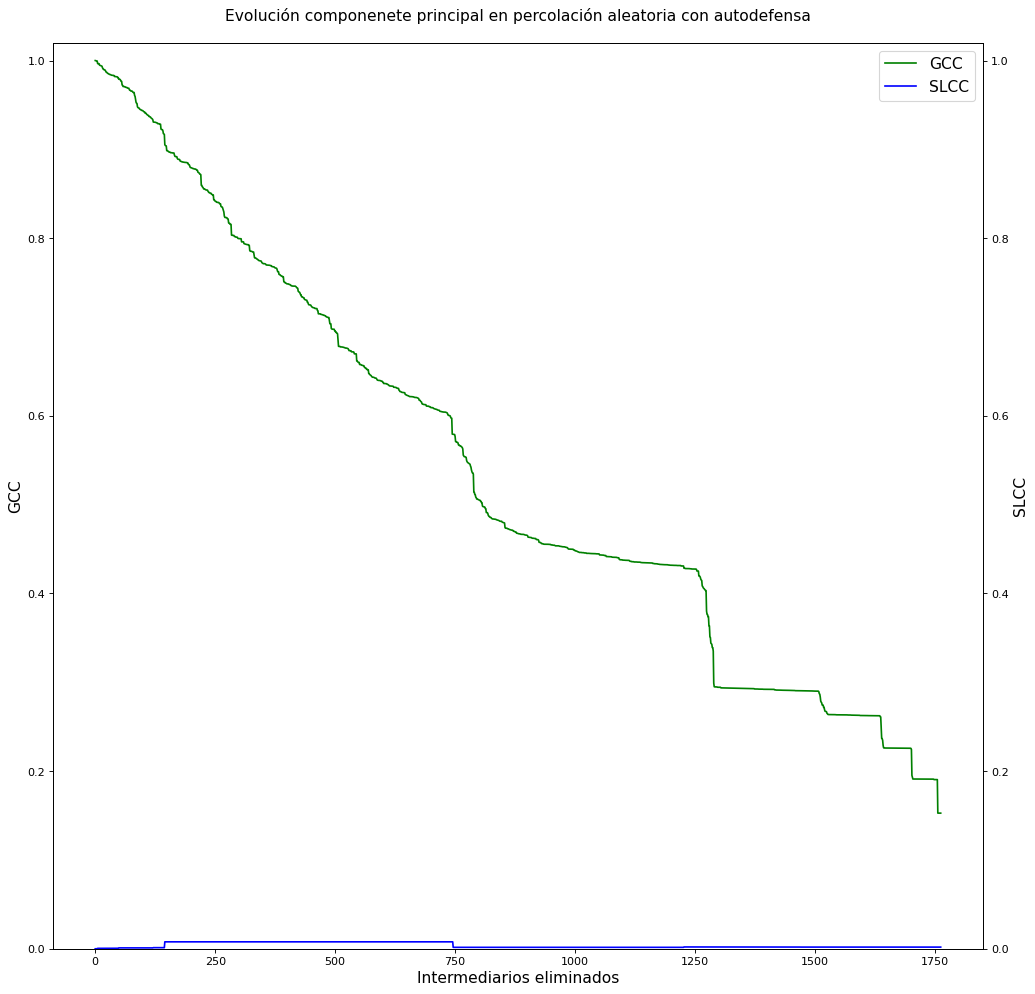

In [24]:
# Random percolation with autodefense plot
fig, ax1 = plt.subplots(figsize=(15,15),dpi=80)
ax1.set_title('Evolución componenete principal en percolación aleatoria con autodefensa',fontsize=14,pad=20)
x_val_gcc = [x[0] for x in scatter_random_gcc]
y_val_gcc = [x[1] for x in scatter_random_gcc]
x_val_sgcc = [x[0] for x in scatter_random_slcc]
y_val_sgcc = [x[1] for x in scatter_random_slcc]

ax2 = ax1.twinx()
lns1 = ax1.plot(x_val_gcc, y_val_gcc, 'g-',label="GCC")
lns2 =ax2.plot(x_val_gcc, y_val_sgcc, 'b-',label="SLCC")
lns = lns1+lns2
ax1.set_xlabel('Intermediarios eliminados',fontsize=14)
ax1.set_ylim([0, 1.02])
ax2.set_ylim([0, 1.02])
ax1.set_ylabel('GCC',fontsize=14)
ax2.set_ylabel('SLCC',fontsize=14)
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0,fontsize=14)

plt.show()

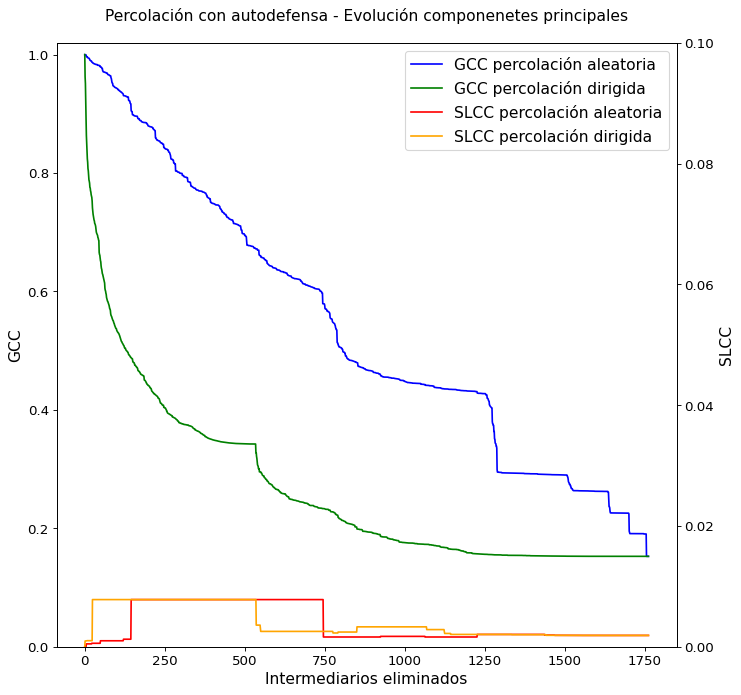

In [27]:
fig, ax1 = plt.subplots(figsize=(10,10),dpi=80)
ax1.set_title('Percolación con autodefensa - Evolución componenetes principales',fontsize=14,pad=20)

x_val_gcc = [x[0] for x in scatter_gcc]
y_val_gcc = [x[1] for x in scatter_gcc]
x_val_sgcc = [x[0] for x in scatter_slcc]
y_val_sgcc = [x[1] for x in scatter_slcc]

x_val_gcc_random = [x[0] for x in scatter_random_gcc]
y_val_gcc_random = [x[1] for x in scatter_random_gcc]
x_val_sgcc_random = [x[0] for x in scatter_random_slcc]
y_val_sgcc_random = [x[1] for x in scatter_random_slcc]

ax2 = ax1.twinx()
lns0 = ax1.plot(x_val_gcc_random, y_val_gcc_random, color='blue',label="GCC percolación aleatoria")
lns1 = ax1.plot(x_val_gcc, y_val_gcc, color='green',label="GCC percolación dirigida")
lns2 = ax2.plot(x_val_sgcc_random, y_val_sgcc_random, color='red',label="SLCC percolación aleatoria")
lns3 =ax2.plot(x_val_gcc, y_val_sgcc, color='orange',label="SLCC percolación dirigida")
lns = lns0+lns1+lns2+lns3
ax1.set_xlabel('Intermediarios eliminados',fontsize=14)
ax1.set_ylim([0, 1.02])
ax2.set_ylim([0, 0.1])
ax1.set_ylabel('GCC',fontsize=14)
ax2.set_ylabel('SLCC',fontsize=14)
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0,fontsize=14)
ax1.tick_params(axis="x", labelsize=12) 
ax1.tick_params(axis="y", labelsize=12)
plt.yticks(fontsize=12)
plt.show()

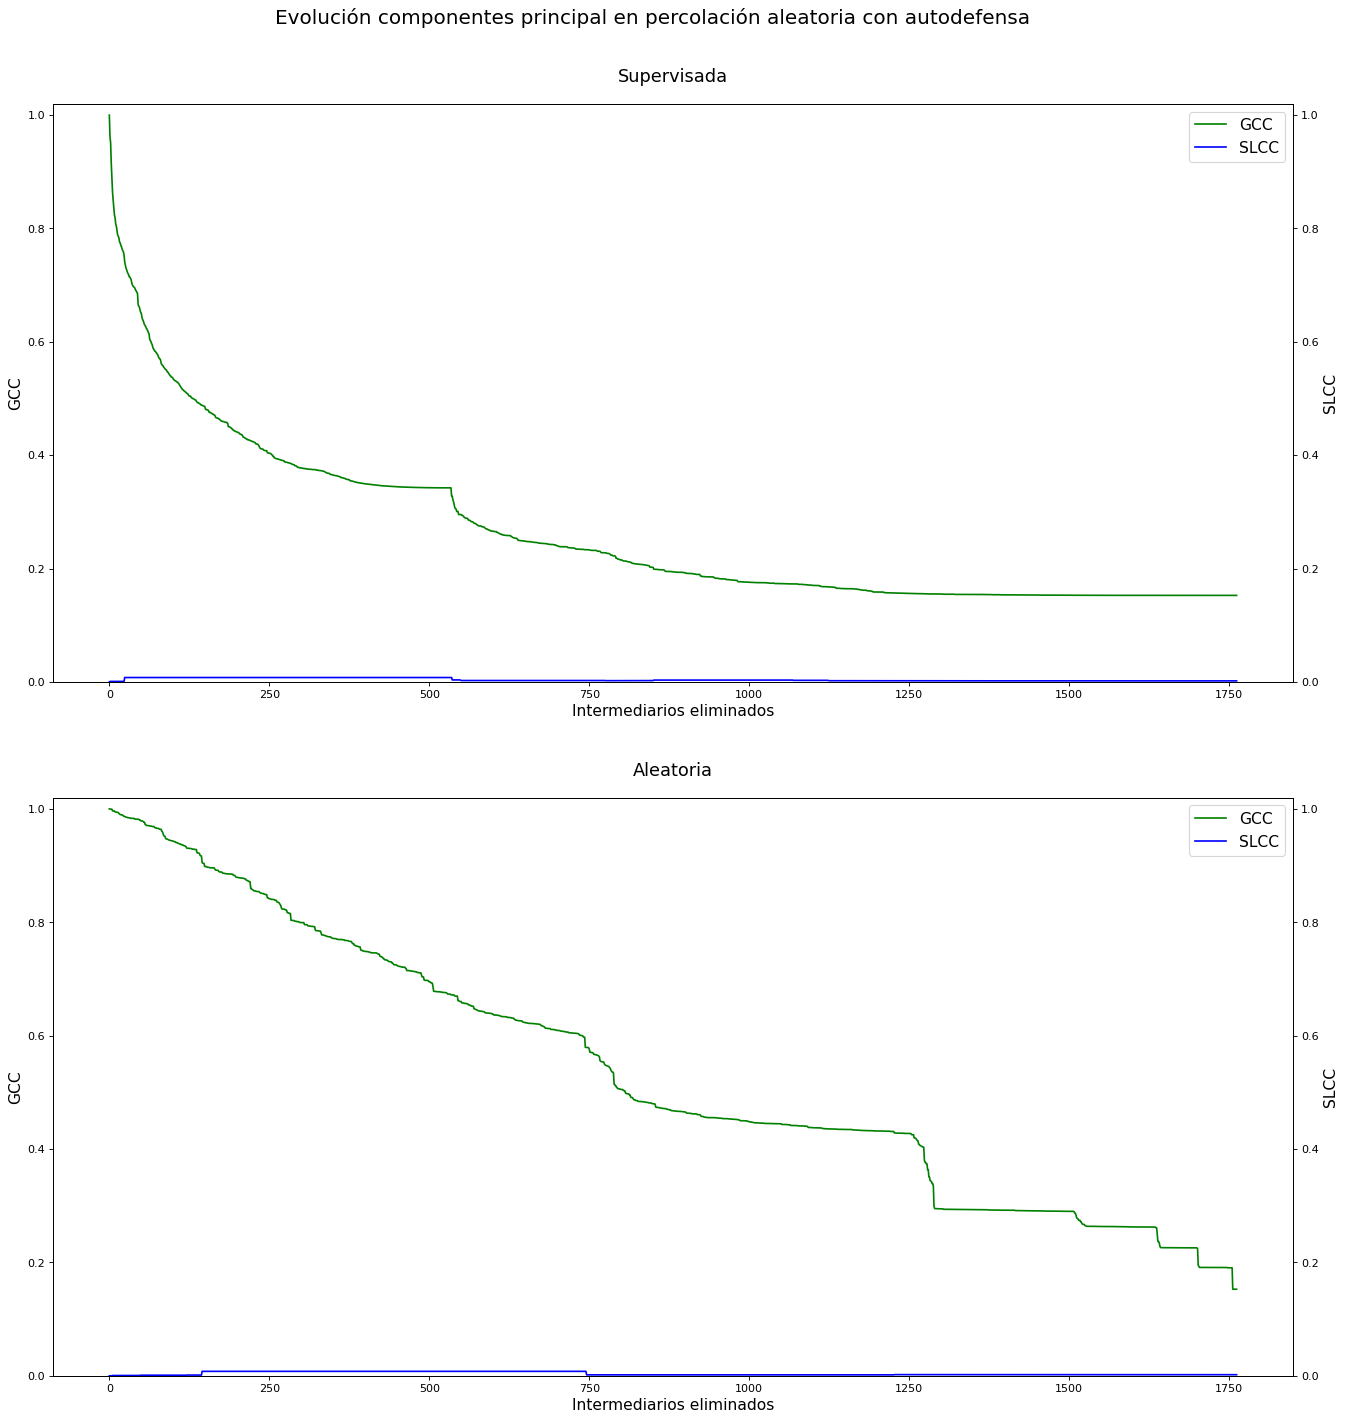

In [25]:
# Percolations with autodefense plot
fig, axs = plt.subplots(2,1,figsize=(20,20),dpi=80)
fig.suptitle('Evolución componentes principal en percolación aleatoria con autodefensa',fontsize=18)
fig.subplots_adjust(top=0.92)

x_val_gcc = [x[0] for x in scatter_gcc]
y_val_gcc = [x[1] for x in scatter_gcc]
x_val_sgcc = [x[0] for x in scatter_slcc]
y_val_sgcc = [x[1] for x in scatter_slcc]

ax2 = axs[0].twinx()
lns1 = axs[0].plot(x_val_gcc, y_val_gcc, 'g-',label="GCC")
lns2 =ax2.plot(x_val_gcc, y_val_sgcc, 'b-',label="SLCC")
lns = lns1+lns2
axs[0].set_xlabel('Intermediarios eliminados',fontsize=14)
axs[0].set_ylim([0, 1.02])
ax2.set_ylim([0, 1.02])
axs[0].set_ylabel('GCC',fontsize=14)
ax2.set_ylabel('SLCC',fontsize=14)
labs = [l.get_label() for l in lns]
axs[0].legend(lns, labs, loc=0,fontsize=14)
axs[0].set_title('Supervisada',fontsize=16,pad=20)

x_val_gcc = [x[0] for x in scatter_random_gcc]
y_val_gcc = [x[1] for x in scatter_random_gcc]
x_val_sgcc = [x[0] for x in scatter_random_slcc]
y_val_sgcc = [x[1] for x in scatter_random_slcc]

ax2 = axs[1].twinx()
lns1 = axs[1].plot(x_val_gcc, y_val_gcc, 'g-',label="GCC")
lns2 =ax2.plot(x_val_gcc, y_val_sgcc, 'b-',label="SLCC")
lns = lns1+lns2
axs[1].set_xlabel('Intermediarios eliminados',fontsize=14)
axs[1].set_ylim([0, 1.02])
ax2.set_ylim([0, 1.02])
axs[1].set_ylabel('GCC',fontsize=14)
ax2.set_ylabel('SLCC',fontsize=14)
labs = [l.get_label() for l in lns]
axs[1].legend(lns, labs, loc=0,fontsize=14)
axs[1].set_title('Aleatoria',fontsize=16,pad=20)
plt.show()